In [1]:
import os
%matplotlib inline
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn

### Neural Networks: Into

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

t_un = 0.1*t_u
t_u_std = (t_u - t_u.mean()) / t_u.std()

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_un = t_un[train_indices].unsqueeze(1)
train_t_c = t_c[train_indices].unsqueeze(1)
train_t_u_std = t_u_std[train_indices].unsqueeze(1)

val_t_un = t_un[val_indices].unsqueeze(1)
val_t_c = t_c[val_indices].unsqueeze(1)
val_t_u_std = t_u_std[val_indices].unsqueeze(1)

In [3]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [4]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [5]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
    t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                f" Validation loss {loss_val.item():.4f}")

In [7]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_u_std,
    t_u_val = val_t_u_std,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

Epoch 1, Training loss 215.6180, Validation loss 89.0777
Epoch 1000, Training loss 2.2681, Validation loss 5.4527
Epoch 2000, Training loss 1.5448, Validation loss 4.8299
Epoch 3000, Training loss 1.4550, Validation loss 4.6992
Epoch 4000, Training loss 1.4216, Validation loss 4.7317
Epoch 5000, Training loss 1.3968, Validation loss 4.8118


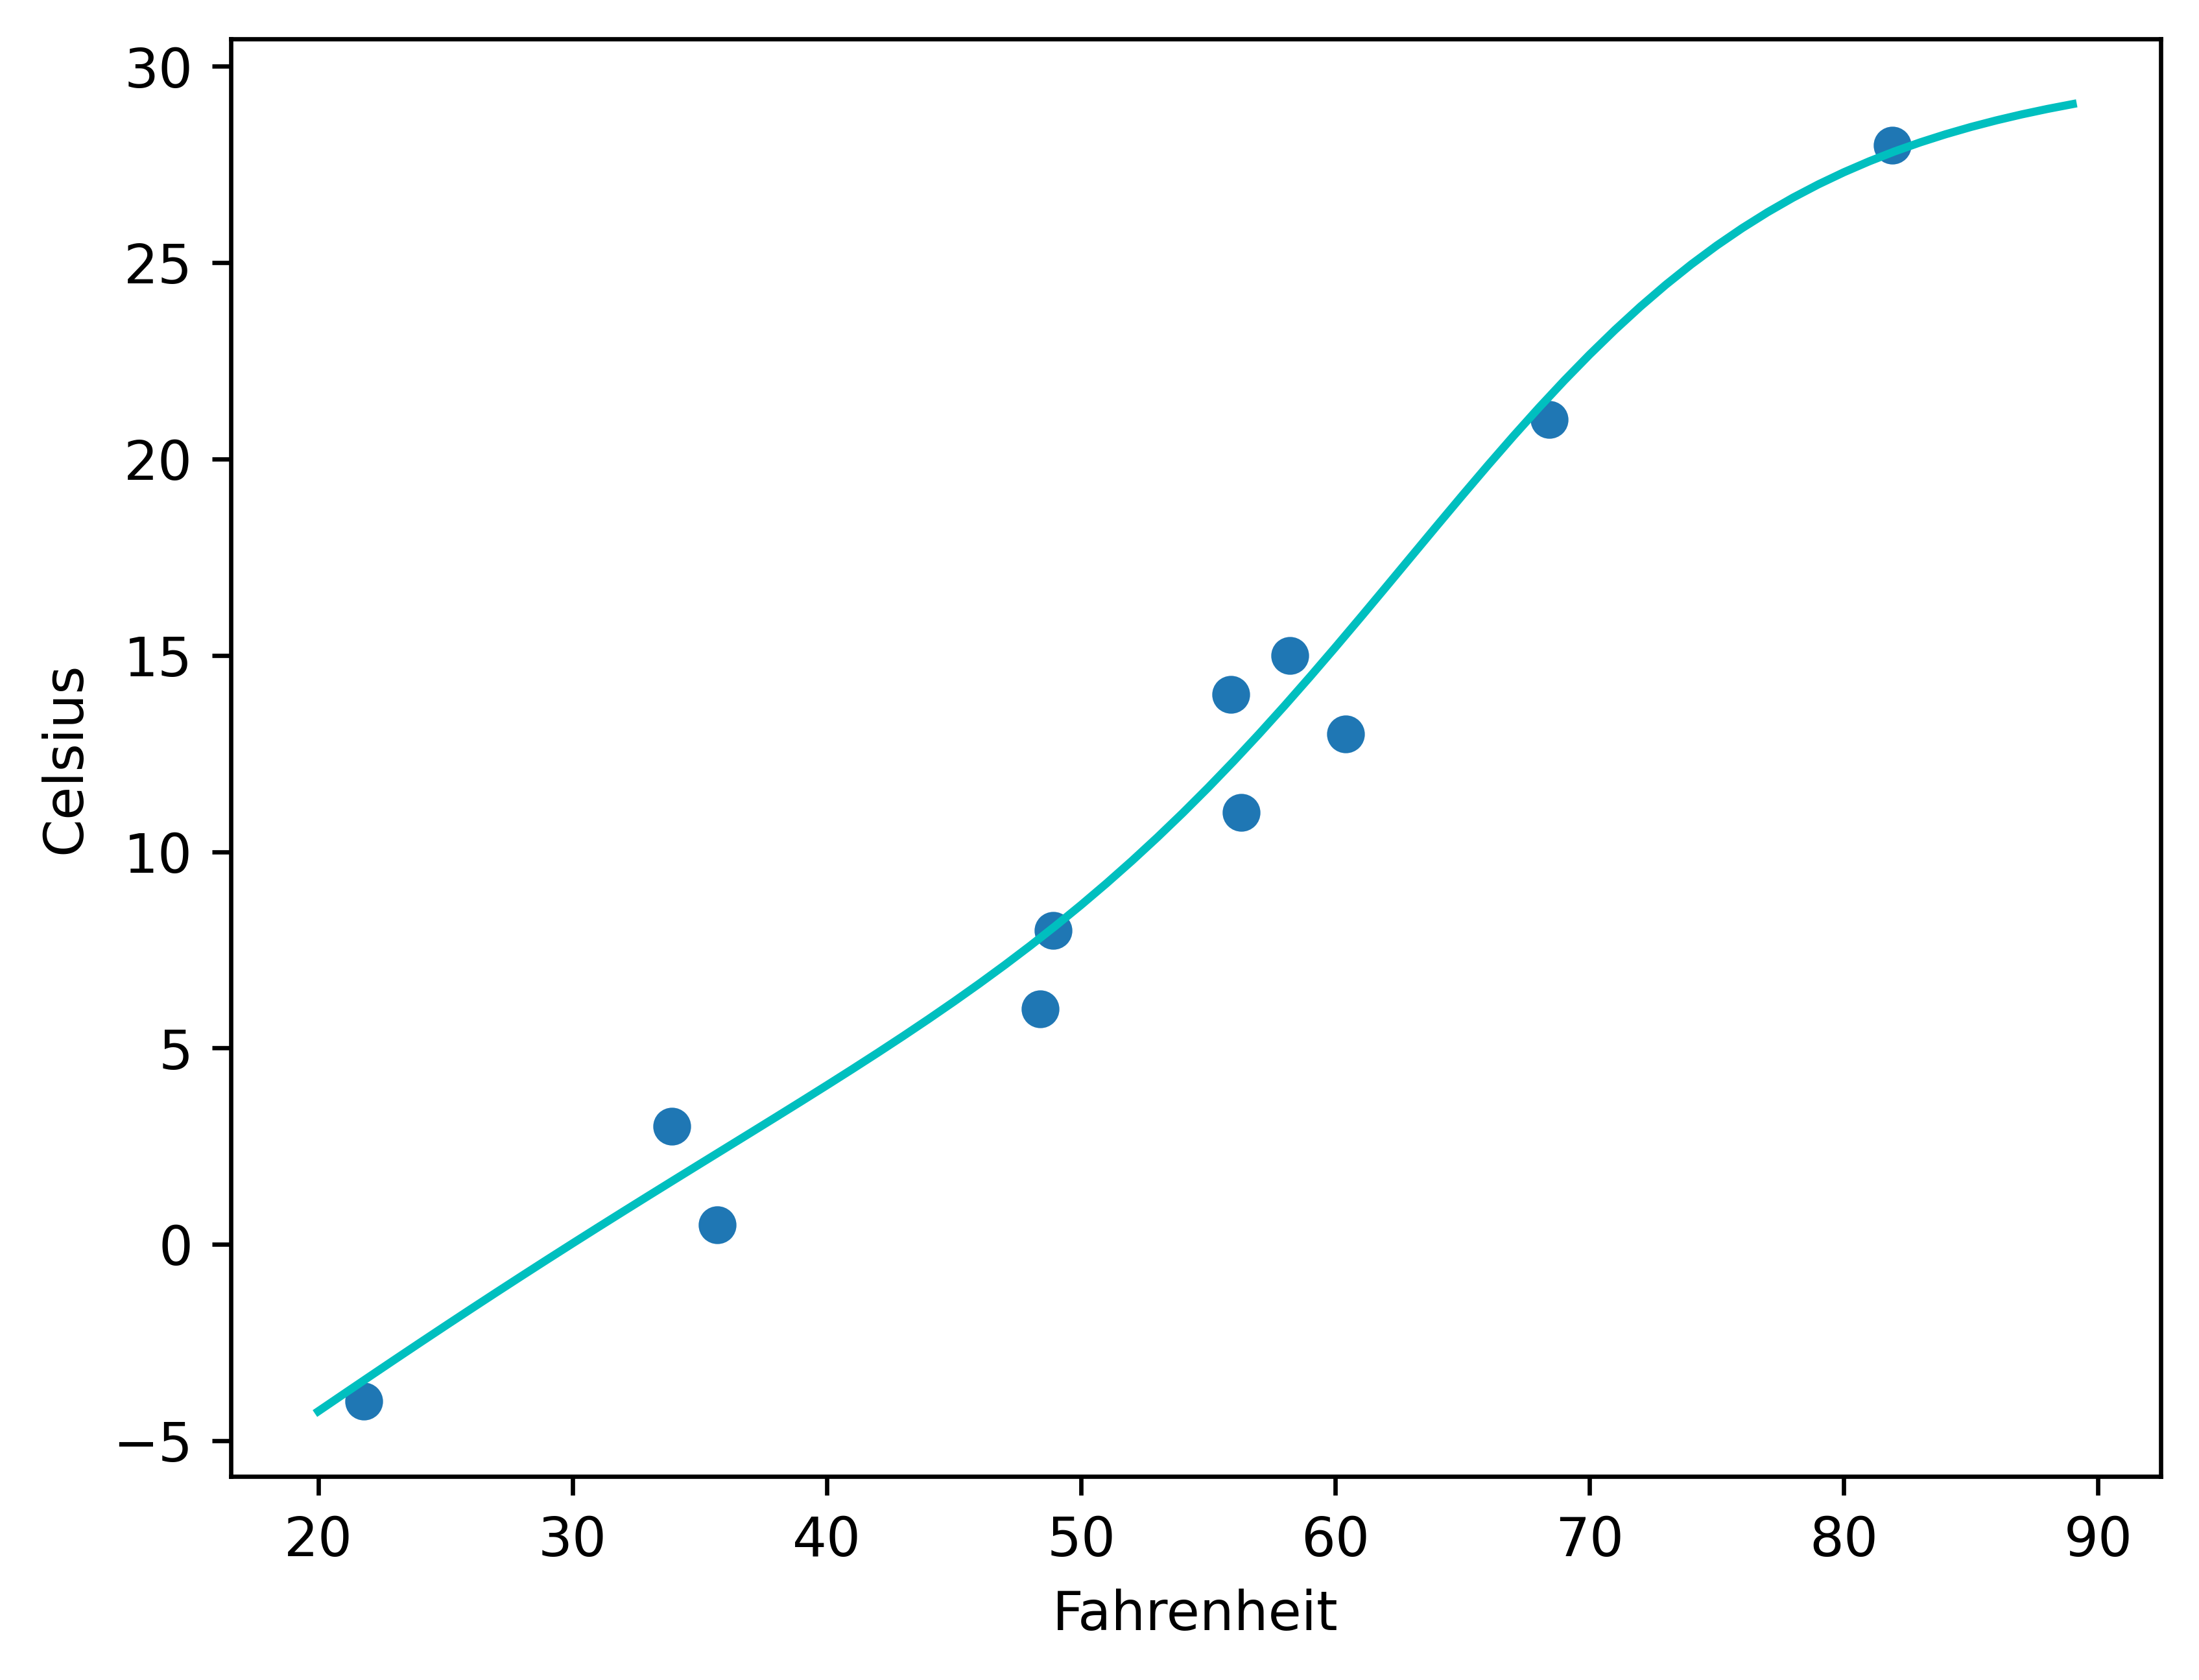

In [10]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
t_range_std = (t_range - t_u.mean()) / t_u.std()
fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(t_range_std).detach().numpy(), 'c-')